# Analiza Visitorjev

In [1]:
import pandas as pd
import os.path
import numpy as np
import math
import matplotlib.pyplot as plt
#heatmap
import seaborn as sns
#interaktivne stvari
import ipywidgets as widgets
#logaritemski scale
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
#svoja legenda
from matplotlib.patches import Patch
from matplotlib.lines import Line2D



#%matplotlib notebook
%matplotlib inline

# naložimo razpredelnico, s katero bomo delali
pot_do_Visitorjev = os.path.join("immadegen.csv")
visitorji = pd.read_csv(pot_do_Visitorjev)
visitorji = visitorji.set_index('Name')

## Obdelava podatkov

In [2]:
visitorji

,Background,Clothing,Expression,Eyes,Eyewear,Head,Mouth,Neck,Nose,Skin,Type,Price
Name,,,,,,,,,,,,
Visitor1,Pink,NaN,Delusional,Visitor,NaN,Barbarian,Face Mask,Gold Necklace,NaN,Green,Not for sale,NaN
Visitor2,Pink,Black T-shirt,Surprised,Twirl,Eyepatch,NaN,NaN,NaN,NaN,Blue,Buy,11.000
Visitor3,Purple,Mariniere,Surprised,Lime,Aviators,Bucket Hat,Face Mask,NaN,NaN,War Paint,Buy,5.000
Visitor4,Green,NaN,Surprised,Navy,Round Glasses,Bolero,Gagged,NaN,Gold Brow Stud,Blue,Not for sale,NaN
Visitor5,Red,Hoodie Down,Confident,Stoned,Round Glasses,Barbarian,Pipe,NaN,Silver Brow Stud,Blue,Not for sale,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Visitor9995,Green,Suit,Surprised,White,Skelly,Do Rag,Fangs,NaN,Clown,Green,Buy,10.000
Visitor9996,Purple,Hoodie With Jacket,Surprised,Lime,NaN,Top Hat,NaN,NaN,Silver Brow Stud,Cyberpunk,Buy,1.000
Visitor9997,Purple,Suit,Tired,Navy,Monocle,Floppy Hat,Gagged,NaN,Silver Brow Stud,Trippy,Not for sale,NaN


## Analiza

Ugotvljanje pogostosti lastnosti

In [3]:
lastnosti = visitorji.columns[0:11]

In [4]:
def redkost(Lastnost):
    return pd.DataFrame(round(visitorji[Lastnost].value_counts()/9999*100, 2))

In [5]:
widgets.interact(redkost, Lastnost=lastnosti[0:10])

interactive(children=(Dropdown(description='Lastnost', options=('Background', 'Clothing', 'Expression', 'Eyes'…

<function __main__.redkost(Lastnost)>

Na spodnjem grafu lahko vidimo, da večina Visitorjev ni na prodaj. Pri naši analizi pa bomo v glavnem uporabljali presotali delež.

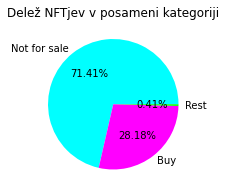

In [6]:
Type = round(visitorji['Type'].value_counts()/9999*100, 2)
prikaz_tipa = Type[Type>1]
prikaz_tipa['Rest'] = Type[Type <= 1].sum()

fig, ax = plt.subplots(figsize = (3, 3))
ax.set_title('Delež NFTjev v posameni kategoriji')
prikaz_tipa.plot.pie(autopct = "%.2f%%", colors = ['aqua', 'fuchsia', 'lime'])
ax.set_ylabel(None)
plt.show()

##### Ugotavljanje pomembnosti posamezne lastnosti

In [7]:
buy = visitorji.loc[visitorji['Type'] == 'Buy']
top_bid = visitorji.loc[visitorji['Type'] == 'Top bid']
min_bid = visitorji.loc[visitorji['Type'] == 'Min bid']

In [8]:
def pomembna_lastnost(Lastnost):
    buy_min = buy['Price'].min()
    top_bid_min = top_bid['Price'].min()
    min_bid_min = min_bid['Price'].min()
    
    df1 = buy.loc[visitorji['Price'] < 5*buy_min][['Price', Lastnost]]
    df2 = top_bid.loc[visitorji['Price'] < 10*top_bid_min][['Price', Lastnost]]
    df3 = min_bid.loc[visitorji['Price'] < 10*min_bid_min][['Price', Lastnost]]
    
    df1 = df1.where(pd.notnull(df1), 'Without')
    df2 = df2.where(pd.notnull(df2), 'Without')
    df3 = df3.where(pd.notnull(df3), 'Without')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4)) 
    df1.plot.scatter('Price', Lastnost, alpha = 0.3, color = 'aqua', ax=ax1, label = 'Buy')
    df2.plot.scatter('Price', Lastnost, alpha = 0.3, color = 'lime', ax=ax2, label = 'Top bid')
    df3.plot.scatter('Price', Lastnost, alpha = 0.3, color = 'fuchsia', ax=ax3, label = 'Min bid')
    plt.tight_layout()


In [9]:
widgets.interact(pomembna_lastnost, Lastnost=lastnosti[0:10])

interactive(children=(Dropdown(description='Lastnost', options=('Background', 'Clothing', 'Expression', 'Eyes'…

<function __main__.pomembna_lastnost(Lastnost)>

Z opazovanjem zgornjih grafov opazimo zanimiv pojav in sicer, da lastnosti, ki doprinesejo več k ceni karticam, ki so napordaj, ne sovpadajo vedno s tistimi, ki doprinesejo k ceni karticam, ki so na dražbi. 

##### Primerjava parov lastnosti

In [10]:
def primerjava_parov(x, y):
    # naredimo tabelo primerno za heatmap
    a = visitorji[x].dropna().unique()
    b = visitorji[y].dropna().unique()

    df_cena = pd.DataFrame(a, columns = [x])
    df_kolicina = pd.DataFrame(a, columns = [x])
    #poiscimo najnizjo ceno in stevilo ujemanj

    for us in b: 
        stolpec_cena = []
        stolpec_kolicina = []
        for ko in a:
            stolpec_kolicina.append(len(buy.loc[(buy[x] == ko) & (buy[y] == us)].index))
            stolpec_cena.append(buy.loc[(buy[x] == ko) & (buy[y] == us)]['Price'].min())
        df_kolicina.insert(1, us, stolpec_kolicina, True)
        df_cena.insert(1, us, stolpec_cena, True)

    df_kolicina = df_kolicina.set_index(x)
    df_cena = df_cena.set_index(x)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4)) 
    # narisemo prvi graf
    
    # poiscemo meje
    ma1 = df_cena.max().max()
    mi1 = df_cena.min().min()
    
    ax = sns.heatmap(df_cena, cmap = 'cool', ax = ax1, norm = LogNorm(mi1,  ma1)) 
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Cena posameznih kombinacij')
    

    # narisemo drugi graf
    ax = sns.heatmap(df_kolicina, cmap = 'cool', ax = ax2)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Število NFTjev s posamezno kombinacijo lastnosti')

    # nastavitve za legendo
    # poiscemo meje
    m2 = df_kolicina.max().max()
    n2 = math.ceil(m2/4)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 9, axis = 'both', which = 'both', length = 0)
    cbar.set_ticks(np.linspace(0, m2, 10))

    plt.tight_layout()


In [11]:
x_select =  widgets.Select(options = lastnosti[0:10])
y_select =  widgets.Select(options = lastnosti[0:10])
widgets.interact(primerjava_parov,y = y_select, x = x_select)

interactive(children=(Select(description='x', options=('Background', 'Clothing', 'Expression', 'Eyes', 'Eyewea…

<function __main__.primerjava_parov(x, y)>

Z opazovanjem zgornjih grafov lahko potrdimo našo hipotezo, da sta količina NFTjev in cena povezani. 
Na levem grafu lahko vidimo ceno posameznih kombinacij, na desnem pa količino. Levi in desni sta v večini primerov obratno obarvana, kar potrdi našo domnevno.

##### Ugotavljanje razmerja med pogostostjo lastnosti in ceno

Ali je kakšna lastnost zviša ceno, ker je lepa in ne, ker je redka?

In [12]:
# razmerje cena, kolicina
def cena(Lastnost):
    stevilo = buy.groupby(Lastnost).size()
    a = pd.DataFrame(stevilo, columns = ['Count'])
    stolpec_cena = []
    v = visitorji[Lastnost].dropna().unique()
    for value in v:
        stolpec_cena.append(buy.loc[(buy[Lastnost] == value)]['Price'].min())
        
    a.insert(1, 'Price', stolpec_cena, True)
    a.insert(2, 'Ratio', round(a['Count']/a['Price'], 2))


    posebna = a.sort_values('Count')['Ratio'][0]
    values = a['Ratio']   
    idx = sorted(v.tolist())
    clrs = ['lime' if (x == posebna) else 'aqua' for x in values ]
    
    fig, ax = plt.subplots(figsize = (12,4))
    plt.bar(idx, values, color = clrs, width = 0.4)
    plt.xticks(rotation = 45, ha = 'right')
    ax.legend([Line2D([0], [0], color = 'lime', lw = 4, label = 'Najredkejša'), 
               Line2D([0], [0], color = 'aqua', lw = 4, label = 'Ostale')], ['Najredkejsa lastnost', 'Ostale'])
    plt.show()


In [13]:
widgets.interact(cena, Lastnost = lastnosti[0:10])

interactive(children=(Dropdown(description='Lastnost', options=('Background', 'Clothing', 'Expression', 'Eyes'…

<function __main__.cena(Lastnost)>

Na temu delu analize sem s pomočjo razmerja med pogostostjo in ceno NFTjev ugotavljala ali obstaja lastnost, ki ni tako zelo redka, pa ima vseeno visoko ceno. Na grafih za kategorije **Neck**, **Head**, **Eyes** in **Clothing** lahko opazimo, da stolpec z najnižjim razmerjem ni tisti, ki je najoblj redek. Iz tega sklepam, da imajo lastnost: *Yellow Jersey* (**Cloting**), *White* (**Eyes**), *Viking* (**Head**) in *Spiked Coller* (**Neck**) višjo ceno, kot bi jo imele, če bi upoštevali le pogostost.

### Ogled NFTjev, ki niso na prodaj

V tem delu analize bom poskusila najti kakšno lastnost, ki jo lastniki ne želijo prodati, temveč želijo tak NFT obdržati zase.

In [14]:
niso_na_prodaj = visitorji.loc[visitorji['Type'] == 'Not for sale']

In [15]:
def f(Lastnost):
    
    # zberemo potrebne podatke
    a = niso_na_prodaj.groupby(Lastnost).size()
    b = visitorji.groupby(Lastnost).size()
    s = pd.DataFrame(a)
    s.insert(1, '1', b, True)
    
    # poiscimo razmerja
    razmerja = []
    for i in range(len(s.index)):
        razmerja.append(round(s.iloc[ i , 0]/s.iloc[ i , 1], 2))
    k = pd.DataFrame(razmerja, columns = ['Razmerje'], index = s.index)
    
    # narisemo graf
    s.plot(kind = 'bar', y = [0, '1'], title = 'Številov Visitorjev z določenimi lastnostmi: ' + Lastnost, 
           color = ['lime', 'fuchsia'])
    plt.legend(["Not for sale", "All"])
    

    
    return k['Razmerje'].sort_values()
    

In [16]:
widgets.interact(f, Lastnost = widgets.ToggleButtons(
    options=lastnosti[0:10], description='Lastnost:', disabled=False,
    tooltips=['Description of slow', 'Description of regular', 'Description of fast']))

interactive(children=(ToggleButtons(description='Lastnost:', options=('Background', 'Clothing', 'Expression', …

<function __main__.f(Lastnost)>

Na zgornjih grafih lahko vidimo, da so deleži večine lastnosti, ki niso na prodaj med 0,60 in 0,75. Te podatki se ujemajo z dejstvom, da je 30% vseh Visitorjev na trgu, ostalih pa lastniki ne prodajajo. Lahko vidimo, da navzgor ni velikega odstopanja, iz česar sklepam, da ni lastnosti, ki bi jo lastniki Visitorjev raje obdržali zase. 
V kategorjah **Head** in **Background** pa je opazno odstopanje navzdol. Le 56% NFTjev z ozadjem *Space* in 53% NFTjev z glavo *Alien VR* ni na prodaj. Zanimivo je, da sta to najbolj redki lastnosti v teh dveh kategorijah. Latniki raje prodajajo te dve redkejši lastnosti od ostalih. Razlog zato je verjetno nepredvidljivost trga, kar povzroči, da se raje prodajajo redkejše lastnosti, ki imajo trenutno visoko ceno, lastniki kartic s pogostejšimi lastnostmi pa mogoče čakajo na vsesplošen dvig vrenosti NFTjev te zbirke. 

## Zaključek

Na začetku projekta sem postavila 4 hipoteze, z analizo pa sem jih nekaj ovrgla in nekaj sprejela. Lahko potrdim, da redkejša lastnost Visitorja doprinese več k ceni NFTja. Po drugi strani pa sem tudi ugotovila, da obstaja nekaj latnosti, ki imajo višjo ceno pa niso tako zelo redke. Menim, da je to zato, ker je lahko kakšna lastnost bolj estetsko privlačna od druge. 
Na koncu analize sem se osredotočila na NFTje, ki niso na prodaj. Ugotovila sem, da ni lastnosti, ki bi jo lastniki raje zadržali zase, je pa nekaj lastnosti, ki jih raje prodajajo - to so tiste, ki so redkejše.